## This is the KrigMapP 

Import all imports

In [1]:
#!pip install --upgrade notebook jupyterlab
#!pip install --upgrade ipython
#!pip install --upgrade certifi
%pip install -r requirements.txt
#!pip install -r nicegui

Note: you may need to restart the kernel to use updated packages.


In [8]:
# Libraries
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from matplotlib.path import Path as MplPath
import contextily as ctx
import matplotlib.ticker as mticker
from scipy.spatial import ConvexHull
import skgstat as skg
import seaborn as sns
from pyproj import Transformer
import os
import glob
import warnings
import io

In [9]:
source_name = [
"2025-06-26-Seibersdorf-PGIS2_dose.input.xlsx"
#,
#"2025-06-26-Seibersdorf_PGIS3.input.xlsx"
]

%matplotlib inline

---READING: 2025-06-26-Seibersdorf-PGIS2_dose.input.xlsx
filename: B_PGIS-89BE_2025_06_26_11_44_39_PEI.csv
longitude: Lon_deg
latitude: Lat_deg
column: DosPGIS_nGypH
site: 2025-06-26-Seibersdorf
detector: PGIS2
quantity: Dose rate (uGy/h)
unitName: dose
constant: 1
utm: 32633
resolution: 1
subsetting: 3
trimmBeginningUpTo: 137
trimmEndAfter: 820
variogramMax: 40


NameError: name 'base64' is not defined

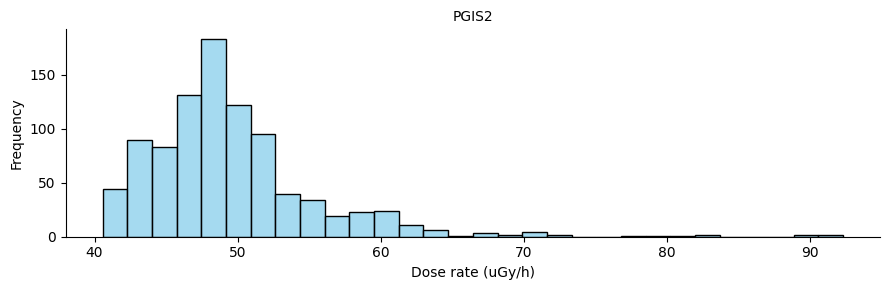

In [10]:

file_fields = ["filename", "longitude", "latitude", "column"]
string_fields = ["site", "detector", "quantity", "unitName"]
num_fields = ["constant", "utm", "resolution","subsetting","trimmBeginningUpTo","trimmEndAfter", "variogramMax"]
crs = 4326
#default values
input_par = {
    "filename": "datafile.xlsx",
    "longitude": "Lon_deg",
    "latitude": "Lat_deg", 
    "column": "DosPGIS_nGypH",
    "site": "2025.06.26_Seib",
    "detector": "PGIS",
    "quantity": "Dose rate (uGy/h)",
    "unitName": "dose",
    "constant": 1.0,
    "utm": 32633,
    "resolution": 1,
    "subsetting": 3,
    "trimmBeginningUpTo": 0, #skip the first N rows and keep the rest (Nth is also trimmed)
    "trimmEndAfter": 1000000, #skip everything after the row N (Nth is kept)
    "variogramMax" : 40
}

if len(source_name) == 0:
    # List all .R files in ./input_par_par_pars
    r_files = glob.glob("inputs/*.input.xlsx")
    # Check if there are any files
    lines = []
    if len(r_files) == 0:
        print("No .input.xlsx files found in './inputs', let us build a new one")
        choice_r = 0
    else:
        lines.append(f"Available .input.xlsx files:")
        for i, f in enumerate(r_files, start=1):
            lines.append(f"{i}: {os.path.basename(f)}")
        lines.append(f"\n Enter the number of the file you want to select:\n (enter 0 if you want to build a new input file) \n")
        msg = "\n".join(lines)
        print(msg)
        choice_r = int(input(msg + "\n"))
    if choice_r == 0:
        d_files = glob.glob("data/*.xlsx") + glob.glob("data/*.csv")
        if len(d_files) == 0:
            raise SystemExit("No data files found in './data'. exiting...")
        else:
            print("Available data files:")
            for i, f in enumerate(d_files, start=1):
                print(f"{i}: {os.path.basename(f)}")
            print("\n Enter the number of the file you want to select\n")
            choice_d = int(input("\n Enter the number of the file you want to select: \n"))
            input_par["filename"] = os.path.basename(d_files[choice_d])
            if input_par["filename"].endswith('.csv'): data = pd.read_csv(f"data/{os.path.basename(d_files[choice_d])}")
            if input_par["filename"].endswith('.xlsx'): data = pd.read_excel(f"data/{os.path.basename(d_files[choice_d])}")
            print("Columns in the data file:")
            cols = data.columns.tolist()
            del data
            for i, f in enumerate(cols):
                print(f"{i}: {os.path.basename(f)}")
            input_par["longitude"] = cols[int(input("\n Enter the number of the longitude column: \n"))]
            input_par["latitude"] = cols[int(input("\n Enter the number of the latitude column: \n"))]
            input_par["column"] = cols[int(input("\n Enter the number of the value column: \n"))]
            for field in string_fields:
                input_par[field] = input(f"Enter {field}: ")
            for field in num_fields:
                input_par[field] = input(f"Enter {field}: ")
            for field in input_par:
                print(input_par[field])
            input_parpd = pd.DataFrame(list(input_par.items()), columns=["Parameter", "Value"])
            input_parpd.to_excel(f"inputs/{input_par["filename"]}_{input_par["unitName"]}output.input.xlsx", index=False)    
    else:
        source_name = [os.path.basename(r_files[choice_r])]

###########################################################

if source_name[0].endswith('.xlsx'): 
    parameters = pd.read_excel(f"inputs/{source_name[0]}")
    print(f"---READING: {source_name[0]}")

for field in file_fields:
    match = parameters.loc[parameters.iloc[:, 0] == field, parameters.columns[1]]
    if not match.empty:
        input_par[field] = str(match.iloc[0])
        print(f"{field}: {input_par[field]}")

for field in string_fields:
    match = parameters.loc[parameters.iloc[:, 0] == field, parameters.columns[1]]
    if not match.empty:
        input_par[field] = str(match.iloc[0])
        print(f"{field}: {input_par[field]}")

for field in num_fields:
    match = parameters.loc[parameters.iloc[:, 0] == field, parameters.columns[1]]
    if not match.empty:
        # Convert to numeric, coerce errors to NaN if non-numeric
        input_par[field] = pd.to_numeric(match.iloc[0], errors="coerce")
        print(f"{field}: {input_par[field]}")

if input_par["filename"].endswith('.csv'): data = pd.read_csv(f"data/{input_par['filename']}")
if input_par["filename"].endswith('.xlsx'): data = pd.read_excel(f"data/{input_par['filename']}")

# Rename columns dynamically using input mapping
data = data.rename(columns={
    input_par["longitude"]: "lon",
    input_par["latitude"]: "lat",
    input_par["column"]: "value"
})
data = data[["lon", "lat", "value"]] # Select only the required columns
data["value"] = data["value"]*input_par["constant"]
data["dataset"] = input_par["detector"]
data_trimmed = data.iloc[input_par["trimmBeginningUpTo"]:input_par["trimmEndAfter"]]
detectorname = input_par["detector"] 


if len(source_name) > 1:
    for src in range(1, len(source_name)):
        input_par["trimmBeginningUpTo"]= 0
        input_par["trimmEndAfter"] = 1000000
        if source_name[src].endswith('.xlsx'): 
            parameters = pd.read_excel(f"inputs/{source_name[src]}")
            print(f"---READING: {source_name[src]}")
        for field in file_fields:
            match = parameters.loc[parameters.iloc[:, 0] == field, parameters.columns[1]]
            if not match.empty:
                input_par[field] = str(match.iloc[0])
                print(f"{field}: {input_par[field]}")
        for field in string_fields:
            match = parameters.loc[parameters.iloc[:, 0] == field, parameters.columns[1]]
            if not match.empty:
                input_par[field] = str(match.iloc[0])
                print(f"{field}: {input_par[field]}")
        for field in num_fields:
            match = parameters.loc[parameters.iloc[:, 0] == field, parameters.columns[1]]
            if not match.empty:
                # Convert to numeric, coerce errors to NaN if non-numeric
                input_par[field] = pd.to_numeric(match.iloc[0], errors="coerce")
                print(f"{field}: {input_par[field]}")
        if input_par["filename"].endswith('.csv'): data_temp = pd.read_csv(f"data/{input_par["filename"]}")
        if input_par["filename"].endswith('.xlsx'): data_temp = pd.read_excel(f"data/{input_par["filename"]}")
        # Rename columns dynamically using input mapping
        data_temp = data_temp.rename(columns={
            input_par["longitude"]: "lon",
            input_par["latitude"]: "lat",
            input_par["column"]: "value"
        })
        data_temp = data_temp[["lon", "lat", "value"]] # Select only the required columns
        data_temp["value"] = data_temp["value"]*input_par["constant"]
        data_temp["dataset"] = input_par["detector"]
        data = pd.concat([data, data_temp], ignore_index=True)
        data_trimmed = pd.concat([data_trimmed, data_temp.iloc[input_par["trimmBeginningUpTo"]:input_par["trimmEndAfter"]]], ignore_index=True)
        detectorname = f"{detectorname}+{input_par["detector"]}" 


###########################################


g = sns.displot(
    data=data,
    x="value",
    row="dataset",     # facet by dataset (rows)
    bins=30,
    color="skyblue",
    edgecolor="black",
    height=3, aspect=3
)
g.set_axis_labels(input_par["quantity"], "Frequency")
g.set_titles(row_template="{row_name}")   # show dataset name on each plot
# Save the figure to a buffer instead of plt.show()
buf = io.BytesIO()
g.fig.savefig(buf, format="png", bbox_inches="tight")
buf.seek(0)

# Encode to base64 for NiceGUI
img_b64 = base64.b64encode(buf.read()).decode("ascii")
ui.image(f"data:image/png;base64,{img_b64}")

plt.close(g.fig)
plt.show()

# Add an original row index to preserve order
data = data.reset_index(drop=False).rename(columns={"index": "original_row"})
# Function to assign groups and ranges safely
def ntile_by_order(df, n_groups=5):
    df = df.copy()
    # Row number within each dataset (starting at 1)
    df["row_in_dataset"] = df.groupby("dataset").cumcount() + 1
    # Total rows per dataset
    n = df.groupby("dataset")["row_in_dataset"].transform("max")
    # Assign group numbers
    df["group"] = np.ceil(df["row_in_dataset"] * n_groups / n).astype(int)
    # Build group ranges once per dataset
    group_ranges = (
        df.groupby(["dataset", "group"])["row_in_dataset"]
        .agg(["min", "max"])
    )
    # Map group labels back
    df["label"] = df.set_index(["dataset", "group"]).index.map(
        lambda idx: f"{group_ranges.loc[idx, 'min']}-{group_ranges.loc[idx, 'max']}"
    )
    return df
#
# Apply grouping
data_new = ntile_by_order(data, n_groups=5)

# Create FacetGrid
g = sns.FacetGrid(
    data_new, 
    row="dataset", col="group", 
    height=3, aspect=1.2,
    sharex=True, sharey=True
)
g.map_dataframe(
    sns.scatterplot,
    x="lon", y="lat",
    hue="value",
    palette="viridis",
    alpha=0.8,
    s=10
)
# Fix aspect ratio
for ax in g.axes.flat:
    ax.set_aspect("equal", adjustable="box")
#
# Legend + axis labels
g.add_legend(title=input_par["quantity"])
g.set_axis_labels("Longitude", "Latitude")
# Set titles with dataset name + row range
for (dataset, group), ax in g.axes_dict.items():
    label = data_new.loc[
        (data_new["dataset"]==dataset) & (data_new["group"]==group),
        "label"
    ].iloc[0]
    ax.set_title(f"{dataset}, {label}")
plt.show()

data = data_trimmed

# Facet by dataset (stacked vertically)
g = sns.FacetGrid(data, row="dataset", height=4, aspect=1.5, sharex=True, sharey=True)
# Scatter plot with color mapped to "value"
g.map_dataframe(
    sns.scatterplot,
    x="lon", y="lat",
    hue="value",
    palette="viridis",
    alpha=0.8,
    s=10   # size of points
)
# Adjust legend and labels
g.add_legend(title=input_par["quantity"])
g.set_axis_labels("Longitude", "Latitude")
g.set_titles(row_template="{row_name}")   # dataset name as facet title
plt.show()

data_utm = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data["lon"], data["lat"]), crs="EPSG:" + str(crs))
data_utm = data_utm.to_crs(epsg=input_par["utm"])

# Create an array of UTM coordinates
utm_coords = np.column_stack((data_utm.geometry.x, data_utm.geometry.y))
# Extract the results from the unique GeoDataFrame
values = data_utm["value"].values

################
# Dimensions for interpolation and later drawings - x,y in meters and lon, lat in degrees
# Precompute min, max, and midpoints
x_min_val, x_max_val = utm_coords[:, 0].min(), utm_coords[:, 0].max()
y_min_val, y_max_val = utm_coords[:, 1].min(), utm_coords[:, 1].max()

transformer = Transformer.from_crs("EPSG:" + str(input_par["utm"]), "EPSG:" + str(crs), always_xy=True)
lon_min, lat_min = transformer.transform(x_min_val, y_min_val)
lon_max, lat_max = transformer.transform(x_max_val, y_max_val)

# Correct aspect ratio for lon/lat
lat_mid = 0.5 * (lat_min + lat_max)
ratio = 1 / np.cos(np.radians(lat_mid))

# Compute number of cells in x and y
x_width = x_max_val - x_min_val
y_width = y_max_val - y_min_val
width = max(x_width, y_width)
x_mid = (x_max_val + x_min_val) / 2.0
y_mid = (y_max_val + y_min_val) / 2.0

# Apply scaling for the figure later
x_min_fig = x_mid - 0.7 * width
x_max_fig = x_mid + 0.7 * width
y_min_fig = y_mid - 0.7 * width
y_max_fig = y_mid + 0.7 * width

# Grid for interpolation
xgrid, ygrid = np.meshgrid(np.linspace(x_min_val, x_max_val, int(x_width / input_par["resolution"])), 
                           np.linspace(y_min_val, y_max_val, int(y_width / input_par["resolution"])))
# Create the convex hull and a Path object from the hull vertices
hull_path = MplPath(utm_coords[ConvexHull(utm_coords).vertices])
# Mask out areas outside the convex hull to avoid extrapolation
mask = hull_path.contains_points(np.c_[xgrid.ravel(), ygrid.ravel()])
mask = mask.reshape(xgrid.shape)

# Convert grids back to the original coordinate reference system for mapping

lon_min_fig, lat_min_fig = transformer.transform(x_min_fig, y_min_fig)
lon_max_fig, lat_max_fig = transformer.transform(x_max_fig, y_max_fig)
lon_grid, lat_grid = transformer.transform(xgrid, ygrid)  # both remain 2D arrays matching xgrid/ygrid

###################################################################

#custom_bins=np.arange(1, 10, 1)

# Create a Variogram object and fit it to the data using custom bin boundaries
# https://scikit-gstat.readthedocs.io/en/latest/reference/variogram.html here are the documentation to tell you 
                                                                        #what are the variogram parameters
variogram = skg.Variogram(
    coordinates= utm_coords, 
    values= values,
    estimator='matheron',
    model='spherical',
    bin_func='even', #so this is saying that the bins will have the same width which is default 1, can be modified 
    #bin_edges=custom_bins ,                 #https://scikit-gstat.readthedocs.io/en/latest/reference/binning.html
    normalize=False,
    use_nugget=True,
    fit_method='trf',
    #fit_sigma='linear',
    #fit_range=10, ##so comment out these range, sill, nugget values if you want,
    #fit_sill=22.79,
    fit_nugget=1.0,
    n_lags=40
    # ,  
    #maxlag=40 
)

print(variogram)

# Plot the variogram
plt.figure()
variogram.plot(show=True)
plt.show()

variogram = skg.Variogram(
    coordinates= utm_coords, 
    values= values,
    estimator='matheron',
    model='spherical',
    bin_func='even', #so this is saying that the bins will have the same width which is default 1, can be modified 
    #bin_edges=custom_bins ,                 #https://scikit-gstat.readthedocs.io/en/latest/reference/binning.html
    normalize=False,
    use_nugget=True,
    fit_method='trf',
    #fit_sigma='linear',
    #fit_range=10, ##so comment out these range, sill, nugget values if you want,
    #fit_sill=22.79,
    fit_nugget=1.0,
    n_lags=40,  
    maxlag=input_par["variogramMax"]
)

print(variogram)

# Plot the variogram
plt.figure()
variogram.plot(show=True)
plt.show()

# Set up Ordinary Kriging with predefined variogram model and control over the number of points used for interpolation
OK = skg.OrdinaryKriging(
    variogram,  # variogram model calculated previously
    min_points=1,  # minimum number of points to include in kriging calculation
    max_points=100,
    # mode='exact'  # maximum number of points to include in kriging calculation
)

# Perform Kriging interpolation
OK.transform(xgrid.ravel(), ygrid.ravel()) 
# ravel() flattens the grid into 1D arrays to feed them into the kriging function.
# Reshape the standard deviations to match the original grid shape to put them back into a 2D raster
Z_sigma = OK.sigma.reshape(xgrid.shape)
Z_pred = OK.z.reshape(xgrid.shape)
Z_sigma = (np.sqrt(Z_sigma) / Z_pred) * 100

Z_pred = np.where(mask, Z_pred, np.nan)  # Apply mask to the interpolated data
Z_sigma = np.where(mask, Z_sigma, np.nan)  # Apply the mask to the standard deviations

###############################################################

fig0, axs0 = plt.subplots()  

# Set axis limits with padding
axs0.set_xlim(lon_min_fig, lon_max_fig)
axs0.set_ylim(lat_min_fig, lat_max_fig)

# basemap for better geographic context
ctx.add_basemap(axs0, crs="EPSG:" + str(crs), source=ctx.providers.Esri.WorldImagery)
                                        # ctx.providers.Esri.WorldImagery,
                                        # ctx.providers.OpenStreetMap.Mapnik,
                                        # ctx.providers.Esri.DeLorme,
                                        # ctx.providers.CartoDB.Positron,
                                        # ctx.providers.CartoDB.DarkMatter,
                                        # ctx.providers.OpenTopoMap,

sc = axs0.scatter(
    data["lon"], data["lat"],       # x and y
    c=data["value"],                # colors
    cmap="viridis",
    alpha=0.5,
    edgecolor="none",
    s=20
)
plt.colorbar(sc, ax=axs0, label='nGy/h')

# Format axis to display longitude and latitude in plain numbers
axs0.xaxis.set_major_formatter(mticker.ScalarFormatter(useOffset=False))
plt.setp(axs0.get_xticklabels(), rotation=-25, ha='center')
axs0.yaxis.set_major_formatter(mticker.ScalarFormatter(useOffset=False))
axs0.set(xlabel='Longitude', ylabel='Latitude', title='Kriging Interpolation with Basemap')

# Save to a file
plt.savefig(f"printouts/{input_par["site"]}-{detectorname}-{input_par["unitName"]}-survey.jpg", dpi=300, bbox_inches="tight")
# plt.savefig("myplot.pdf", dpi=300, bbox_inches="tight")

plt.show()

######################################################

# plot to visualise the interpolated data
fig1, axs1 = plt.subplots()  

# Set axis limits with padding
axs1.set_xlim(lon_min_fig, lon_max_fig)
axs1.set_ylim(lat_min_fig, lat_max_fig)

# basemap for better geographic context
ctx.add_basemap(axs1, crs="EPSG:" + str(crs), source=ctx.providers.Esri.WorldImagery)
                                        # ctx.providers.Esri.WorldImagery,
                                        # ctx.providers.OpenStreetMap.Mapnik,
                                        # ctx.providers.Esri.DeLorme,
                                        # ctx.providers.CartoDB.Positron,
                                        # ctx.providers.CartoDB.DarkMatter,
                                        # ctx.providers.OpenTopoMap,

im = axs1.imshow(
    Z_pred,
    origin='lower',
    extent=(lon_grid.min(), lon_grid.max(), lat_grid.min(), lat_grid.max()),
    aspect= ratio,
    cmap='viridis',
    interpolation='none',  # show actual values per cell,
    alpha=0.5
)
plt.colorbar(im, ax=axs1, label='nGy/h')

# Format axis to display longitude and latitude in plain numbers
axs1.xaxis.set_major_formatter(mticker.ScalarFormatter(useOffset=False))
plt.setp(axs1.get_xticklabels(), rotation=-25, ha='center')
axs1.yaxis.set_major_formatter(mticker.ScalarFormatter(useOffset=False))
axs1.set(xlabel='Longitude', ylabel='Latitude', title=f"{input_par["site"]} {detectorname} kriging")

# Save to a file
plt.savefig(f"printouts/{input_par["site"]}-{detectorname}-{input_par["unitName"]}-krig.jpg", dpi=300, bbox_inches="tight")
# plt.savefig("myplot.pdf", dpi=300, bbox_inches="tight")

plt.show()

########################################################################

# plot to visualise the interpolated data
fig2, axs2 = plt.subplots()  # Create a subplot with 2 columns

axs2.set_xlim(lon_min_fig, lon_max_fig)
axs2.set_ylim(lat_min_fig, lat_max_fig)

# basemap for better geographic context
ctx.add_basemap(axs2, crs="EPSG:" + str(crs), source=ctx.providers.Esri.WorldImagery)

im = axs2.imshow(
    Z_sigma,
    origin='lower',
    extent=(lon_grid.min(), lon_grid.max(), lat_grid.min(), lat_grid.max()),
    aspect= ratio,
    cmap='viridis',
    interpolation='none',  # show actual values per cell,
    alpha=0.5
)
plt.colorbar(im, ax=axs2, label='Uncertainty [%]')

# Format axis to display longitude and latitude in plain numbers
axs2.xaxis.set_major_formatter(mticker.ScalarFormatter(useOffset=False))
plt.setp(axs2.get_xticklabels(), rotation=-25, ha='center')
axs2.yaxis.set_major_formatter(mticker.ScalarFormatter(useOffset=False))

axs2.set_xlabel('Longitude')
axs2.set_ylabel('Latitude')
axs2.set_title('Kriging Standard Deviations with Basemap')
# Save to a file
plt.savefig(f"printouts/{input_par["site"]}-{detectorname}-{input_par["unitName"]}-krig_unc.jpg", dpi=300, bbox_inches="tight")
plt.show()





import rasterio
from rasterio.transform import from_origin


# Flip vertically so north is up
Z_export = np.flipud(Z_pred)
# Define pixel size (degrees) from grid spacing
xres = (lon_grid.max() - lon_grid.min()) / (lon_grid.shape[1] - 1)
yres = (lat_grid.max() - lat_grid.min()) / (lat_grid.shape[0] - 1)

# Affine transform for raster
transform = from_origin(lon_grid.min(), lat_grid.max(), xres, yres)

# Save GeoTIFF
with rasterio.open(
    "rasters/raster-krig.tif",
    "w",
    driver="GTiff",
    height=Z_export.shape[0],
    width=Z_export.shape[1],
    count=1,
    dtype=Z_export.dtype,
    crs="EPSG:" + str(crs),  # WGS84
    transform=transform
    #,
    #nodata=-9999
) as dst:
    dst.write(Z_export, 1)
